In [909]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [910]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied

In [911]:
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY = HPI_PO.YoY.astype(float)

In [912]:
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates


In [913]:
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)

In [914]:
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)

In [915]:
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values

In [916]:
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100

In [917]:
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover

In [918]:
HCAI = pd.read_excel("HCAI.xlsx", sheet_name="Whole Market")
HCAI
new_header = HCAI.loc[2]
HCAI = HCAI[3:]
HCAI.columns = new_header
HCAI = HCAI[HCAI.columns[:6]]
HCAI.rename(columns={"Year" : "DATE"}, inplace=True)
HCAI.DATE = HCAI.DATE.apply(lambda x: str(x).split()[0])
DATE = HCAI.DATE.values
Quarter = HCAI.Quarter.values
new_dates = []
for i in range(len(DATE)):
    if Quarter[i] == 1:
        new_dates.append(DATE[i]+"-01-01")
    elif Quarter[i] == 2:
        new_dates.append(DATE[i]+"-04-01")
    elif Quarter[i] == 3:
        new_dates.append(DATE[i]+"-07-01")
    elif Quarter[i] == 4:
        new_dates.append(DATE[i]+"-10-01")
    else:
        raise ValueError("Invalid value for quarter")
HCAI.DATE = new_dates
HCAI.DATE = pd.to_datetime(HCAI.DATE)
HCAI.columns = [x.replace("\n", '') for x in HCAI.columns.to_list()]
HCAI = HCAI.iloc[4:,[0,3]]
df = pd.merge(HPI_PO, HCAI, on='DATE', how='outer')
#df.dropna(subset=["Implied_Turnover"], inplace = True)
df.fillna(method='ffill',inplace= True)

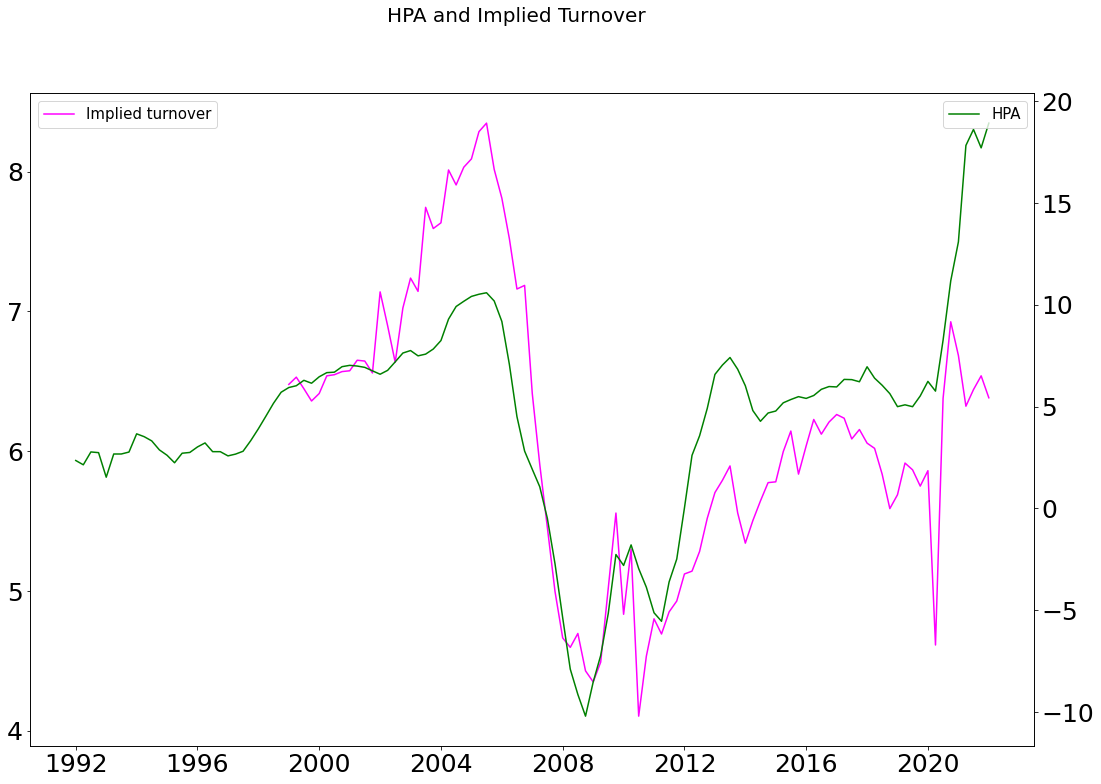

In [1018]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df.DATE, df.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta')
ax2 = ax1.twinx()
ax2.plot(df.DATE, df.YoY, linewidth=1.5,color='green',label='HPA')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)
fig.suptitle("HPA and Implied Turnover", size = 20)
plt.show()
fig.savefig("HPIvsIT.png")

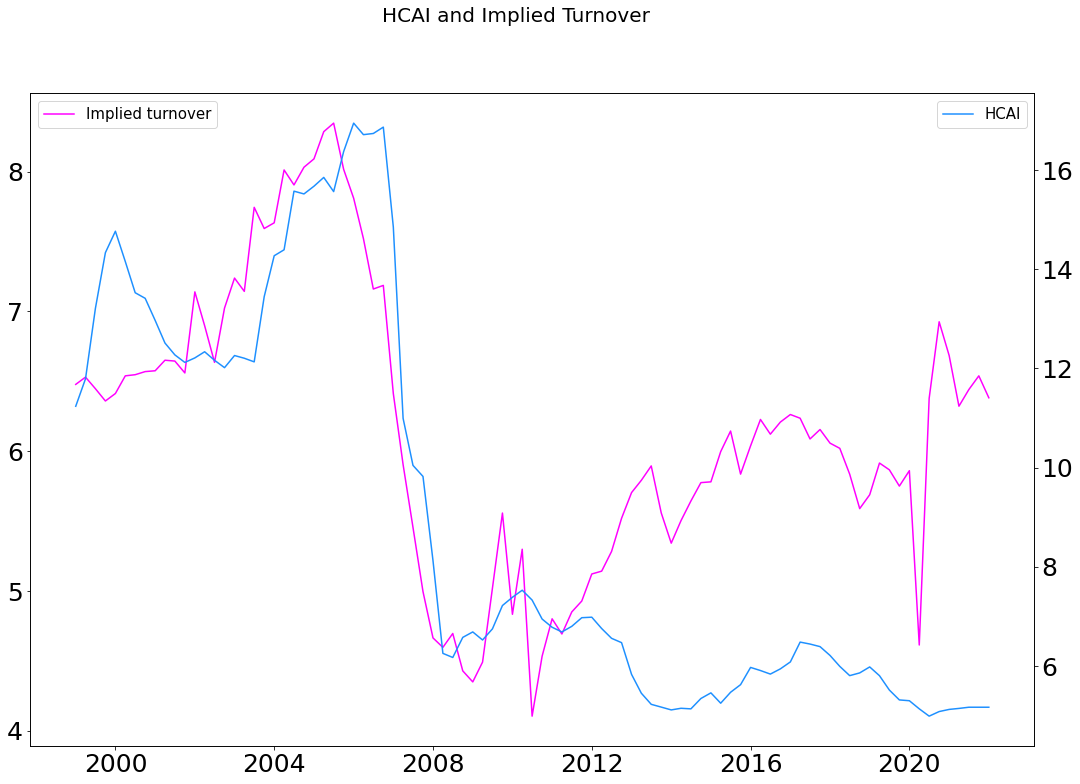

In [1019]:
from datetime import datetime
import matplotlib.dates as mdates
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df.DATE, df.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta', markersize=22)
ax2 = ax1.twinx()
ax2.plot(df.DATE,df.TotalRisk, linewidth=1.5,color='dodgerblue',label='HCAI')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("HCAI and Implied Turnover", size = 20)
ax1.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='major', labelsize=25)
plt.show()
fig.savefig("HCAIvsIT.png")

## Selecting most effective predictors

In [921]:
import statsmodels.api as sm

ModelDescription ={}
for i in range(1,YoY_windows):
    s="YoY_MA_Window%i"%i
    df[s] = df.YoY.rolling(i).mean()
    data = df.dropna(subset=["Implied_Turnover"])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm =sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data = data).fit()
    ModelDescription[model_name]["model"] = lm
    
for j in range(1, TR_windows):
    s = "TR_MA_Window%i"%j
    df[s] = df.TotalRisk.rolling(j).mean()
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm =sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data = data).fit()
    ModelDescription[model_name]["model"] = lm

for lag in range(1,lags):
    s = "YoY_Lag%i"%lag
    df[s] = df.YoY.shift(lag)
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data= data).fit()
    ModelDescription[model_name]["model"] = lm
for lag in range(1,lags):
    s = "TR_Lag%i"%lag
    df[s] = df.TotalRisk.shift(lag)
    data = df.dropna(subset=["Implied_Turnover", s])
    model_name = "model_"+s
    ModelDescription[model_name] = {"Features" : s}
    lm = sm.OLS.from_formula("Implied_Turnover ~ %s"%s, data= data).fit()
    ModelDescription[model_name]["model"] = lm

In [922]:
for i in (ModelDescription.values()):
    print(i["Features"], )
    print('R_squared = ',i["model"].rsquared,'\n\n')

YoY_MA_Window1
R_squared =  0.525476372907772 


YoY_MA_Window2
R_squared =  0.5429542948729017 


YoY_MA_Window3
R_squared =  0.5595540470478273 


YoY_MA_Window4
R_squared =  0.574113051242837 


YoY_MA_Window5
R_squared =  0.5875685330163019 


YoY_MA_Window6
R_squared =  0.5967890004441652 


YoY_MA_Window7
R_squared =  0.6004509257356379 


YoY_MA_Window8
R_squared =  0.6001470541875815 


YoY_MA_Window9
R_squared =  0.595656649248811 


YoY_MA_Window10
R_squared =  0.5884931910186406 


YoY_MA_Window11
R_squared =  0.5793009756928469 


TR_MA_Window1
R_squared =  0.5022529310514938 


TR_MA_Window2
R_squared =  0.477244062645132 


TR_MA_Window3
R_squared =  0.4504007422555968 


TR_MA_Window4
R_squared =  0.42084640365366943 


TR_MA_Window5
R_squared =  0.38956648330365495 


TR_MA_Window6
R_squared =  0.3571370440801769 


TR_MA_Window7
R_squared =  0.32463176257480175 


TR_MA_Window8
R_squared =  0.29382227844998543 


TR_MA_Window9
R_squared =  0.26435325983703606 


TR_MA_

In [949]:
data = df.dropna(subset= ["Implied_Turnover", "TotalRisk"])
lm = sm.OLS.from_formula("Implied_Turnover ~ TotalRisk+ YoY_MA_Window6", data = data.iloc[:-10,:]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     235.0
Date:                Tue, 26 Jul 2022   Prob (F-statistic):           3.24e-34
Time:                        11:34:43   Log-Likelihood:                -40.619
No. Observations:                  83   AIC:                             87.24
Df Residuals:                      80   BIC:                             94.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.4747      0.117     38.

In [954]:
#data[["TotalRisk", "YoY_MA_Window6"]].iloc[-10:,:]
pred = lm.predict(data[["TotalRisk", "YoY_MA_Window6"]].iloc[-8:,:])
np.sqrt(mean_squared_error(pred,data.Implied_Turnover.iloc[-8:]))
pred = lm.predict(data[["TotalRisk", "YoY_MA_Window6"]].iloc[-18:-10,:])
np.sqrt(mean_squared_error(pred,data.Implied_Turnover.iloc[-18:-10]))


0.1855716572152416

In [955]:
data[["DATE","TotalRisk", "YoY_MA_Window6"]].iloc[-10:,:]

DATE  TotalRisk  YoY_MA_Window6
111 2019-10-01   5.315952        5.382112
112 2020-01-01   5.300125        5.413953
113 2020-04-01   5.136688        5.434733
114 2020-07-01   4.989182        5.978195
115 2020-10-01   5.081624        6.992047
116 2021-01-01   5.124921        8.340382
117 2021-04-01   5.144927       10.389318
118 2021-07-01   5.169036       12.450357
119 2021-10-01   5.169036       14.440235
120 2022-01-01   5.169036       16.216025

In [873]:
weights = np.array([0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
X_YoY["YoY_weigheted_MA"] = X_YoY.YoY.rolling(6).apply(lambda x: np.sum(weights*x)).head(10)

In [928]:
pred = lm.predict(data[["TotalRisk", "YoY_MA_Window6"]])

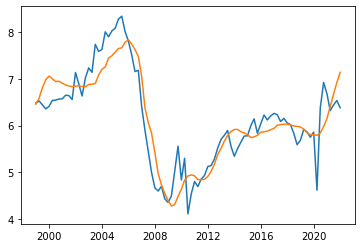

In [931]:
plt.plot(data.DATE, data.Implied_Turnover)
plt.plot(data.DATE, pred)

In [944]:
df["YoY_MA4_Lag2"] = df.YoY.shift(2).rolling(4).mean()
data = df.dropna(subset= ["Implied_Turnover", "TotalRisk"])
data

DATE       YoY  Implied_Turnover  TotalRisk  YoY_MA_Window1  \
28  1999-01-01   5.93694          6.477936  11.235860         5.93694   
29  1999-04-01   6.02527          6.529750  11.789989         6.02527   
30  1999-07-01   6.29097          6.447134  13.208564         6.29097   
31  1999-10-01   6.14804          6.359195  14.332389         6.14804   
32  2000-01-01   6.46462          6.412796  14.764346         6.46462   
..         ...       ...               ...        ...             ...   
116 2021-01-01  13.08681          6.684530   5.124921        13.08681   
117 2021-04-01  17.81826          6.321918   5.144927        17.81826   
118 2021-07-01  18.60512          6.440745   5.169036        18.60512   
119 2021-10-01  17.70045          6.539117   5.169036        17.70045   
120 2022-01-01  18.91433          6.382089   5.169036        18.91433   

     YoY_MA_Window2  YoY_MA_Window3  YoY_MA_Window4  YoY_MA_Window5  \
28         5.821415        5.601410        5.333285        5.049380   
29         5.981105        5.889367        5.707375        5.471682   
30         6.158120        6.084393        5.989768        5.824094   
31         6.219505        6.154760        6.100305        6.021422   
32         6.306330        6.301210        6.232225        6.173168   
..              ...             ...             ...             ...   
116       12.128995       10.839193        9.569690        8.903530   
117       15.452535       14.025417       12.583960       11.219404   
118       18.211690       16.503397       15.170343       13.788192   
119       18.152785       18.041277       16.802660       15.676364   
120       18.307390       18.406633       18.259540       17.224994   

     YoY_MA_Window6  ...    TR_Lag1    TR_Lag2    TR_Lag3    TR_Lag4  \
28         4.762640  ...        NaN        NaN        NaN        NaN   
29         5.212028  ...  11.235860        NaN        NaN        NaN   
30         5.608230  ...  11.789989  11.235860        NaN        NaN   
31         5.878085  ...  13.208564  11.789989  11.235860        NaN   
32         6.095288  ...  14.332389  13.208564  11.789989  11.235860   
..              ...  ...        ...        ...        ...        ...   
116        8.340382  ...   5.081624   4.989182   5.136688   5.300125   
117       10.389318  ...   5.124921   5.081624   4.989182   5.136688   
118       12.450357  ...   5.144927   5.124921   5.081624   4.989182   
119       14.440235  ...   5.169036   5.144927   5.124921   5.081624   
120       16.216025  ...   5.169036   5.169036   5.144927   5.124921   

     YoY_MA6_Lag2  YoY_MA5_Lag1  YoY_MA6_Lag1  YoY_MA4_Lag1  YoY_MA5_Lag2  \
28       3.734988      4.527780      4.241275      4.827490      3.948352   
29       4.241275      5.049380      4.762640      5.333285      4.527780   
30       4.762640      5.471682      5.212028      5.707375      5.049380   
31       5.212028      5.824094      5.608230      5.989768      5.471682   
32       5.608230      6.021422      5.878085      6.100305      5.824094   
..            ...           ...           ...           ...           ...   
116      5.978195      7.391096      6.992047      7.857710      6.156220   
117      6.992047      8.903530      8.340382      9.569690      7.391096   
118      8.340382     11.219404     10.389318     12.583960      8.903530   
119     10.389318     13.788192     12.450357     15.170343     11.219404   
120     12.450357     15.676364     14.440235     16.802660     13.788192   

     YoY_MA4_Lag2  
28       4.233252  
29       4.827490  
30       5.333285  
31       5.707375  
32       5.989768  
..            ...  
116      6.446075  
117      7.857710  
118      9.569690  
119     12.583960  
120     15.170343  

[93 rows x 40 columns]

In [945]:
lm = sm.OLS.from_formula("Implied_Turnover ~ YoY_MA4_Lag2", data = data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Implied_Turnover   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     118.7
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           3.52e-18
Time:                        10:56:58   Log-Likelihood:                -93.039
No. Observations:                  93   AIC:                             190.1
Df Residuals:                      91   BIC:                             195.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.4857      0.091     60.163      0.000       5.305       5.667
YoY_MA4_Lag2     0.1505      0.014     10.894      0.000       0.123       0.178
==============================================================================
Omnibus:                        1.097   Durbin-Watson:                   0.323
Prob(Omnibus):                  0.578   Jarque-Bera (JB):                1.112
Skew:                           0.251   Prob(JB):                        0.573
Kurtosis:                       2.811   Cond. No.                         8.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""